In this article, I discuss one of my submissions for the IMC prosperity trading competition.
In the first round, we were tasked to develop a trading strategy for a ficitional security called AMETHYSTS.
We were given price data for 3 tading days, each day being divided into 10000 timestamps.

# I) Processing the data

We received the data semicolon delimited CSV files. The content of the file looked like this:

![title](images/csv_file_initial_format.png)

#### Let's open one of the files to see what the content looks like

In [95]:
import pandas as pd

Prices_t_minus_0 = pd.read_csv('prices_round_1_day_0.csv',delimiter = ";")
Prices_t_minus_0.head()
#Since the file contains the prices for other securities, I only select the prices for AMETHYSTS and output them to a new file
mydf0 = Prices_t_minus_0[Prices_t_minus_0['product']== 'AMETHYSTS']
#mydf0.to_csv('price_data_minus_0_AMETHYSTS.csv', index=False)
mydf0.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,AMETHYSTS,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
2,0,100,AMETHYSTS,9996,1,9995.0,30.0,NaN,NaN,10002,6,10004.0,1.0,10005.0,30.0,9999.0,0.0
4,0,200,AMETHYSTS,9996,1,9995.0,21.0,NaN,NaN,10004,1,10005.0,21.0,NaN,NaN,10000.0,0.0
7,0,300,AMETHYSTS,9996,2,9995.0,23.0,NaN,NaN,9998,3,10004.0,2.0,10005.0,23.0,9997.0,0.0
8,0,400,AMETHYSTS,9998,5,9996.0,2.0,9995.0,23.0,10004,2,10005.0,23.0,NaN,NaN,10001.0,0.0


The orders for the 3 days were given in 3 separate files. I store the results of the 3 files in dataframes, then I concatenate the dataframes

In [96]:
Prices_t_minus_1 = pd.read_csv('prices_round_1_day_-1.csv',delimiter = ";")
Prices_t_minus_1.head()
#Since the file contains the prices for other securities, I only select the prices for AMETHYSTS and output them to a new file
mydf1 = Prices_t_minus_1[Prices_t_minus_1['product']== 'AMETHYSTS']
#mydf0.to_csv('price_data_minus_0_AMETHYSTS.csv', index=False)
mydf1.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-1,0,AMETHYSTS,10002,1,9996.0,2.0,9995.0,29.0,10004,2,10005.0,29.0,NaN,NaN,10003.0,0.0
3,-1,100,AMETHYSTS,9996,2,9995.0,22.0,NaN,NaN,10004,2,10005.0,22.0,NaN,NaN,10000.0,0.0
4,-1,200,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10000.0,0.0
6,-1,300,AMETHYSTS,9996,2,9995.0,29.0,NaN,NaN,10004,2,10005.0,29.0,NaN,NaN,10000.0,0.0
8,-1,400,AMETHYSTS,9996,2,9995.0,25.0,NaN,NaN,10004,2,10005.0,25.0,NaN,NaN,10000.0,0.0


In [97]:
Prices_t_minus_2 = pd.read_csv('prices_round_1_day_-2.csv',delimiter = ";")
Prices_t_minus_2.head()
#Since the file contains the prices for other securities, I only select the prices for AMETHYSTS and output them to a new file
mydf2 = Prices_t_minus_2[Prices_t_minus_2['product']== 'AMETHYSTS']
#mydf0.to_csv('price_data_minus_0_AMETHYSTS.csv', index=False)
mydf2.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
5,-2,200,AMETHYSTS,9996,1,9995.0,30.0,NaN,NaN,10004,1,10005.0,30.0,NaN,NaN,10000.0,0.0
6,-2,300,AMETHYSTS,9996,1,9995.0,26.0,NaN,NaN,10004,1,10005.0,26.0,NaN,NaN,10000.0,0.0
8,-2,400,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,9998,3,10002.0,9.0,10005.0,20.0,9996.5,0.0


In [98]:
mydf_all = pd.concat([mydf2,mydf1,mydf0])
mydf_all.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
5,-2,200,AMETHYSTS,9996,1,9995.0,30.0,NaN,NaN,10004,1,10005.0,30.0,NaN,NaN,10000.0,0.0
6,-2,300,AMETHYSTS,9996,1,9995.0,26.0,NaN,NaN,10004,1,10005.0,26.0,NaN,NaN,10000.0,0.0
8,-2,400,AMETHYSTS,9995,20,NaN,NaN,NaN,NaN,9998,3,10002.0,9.0,10005.0,20.0,9996.5,0.0


# II) Visualizing the data and finding a strategy

After concatenating the price and volumes for the 3 days, I plot the mid prices (average of best bid and best ask) to see if there's a pattern

<AxesSubplot:>

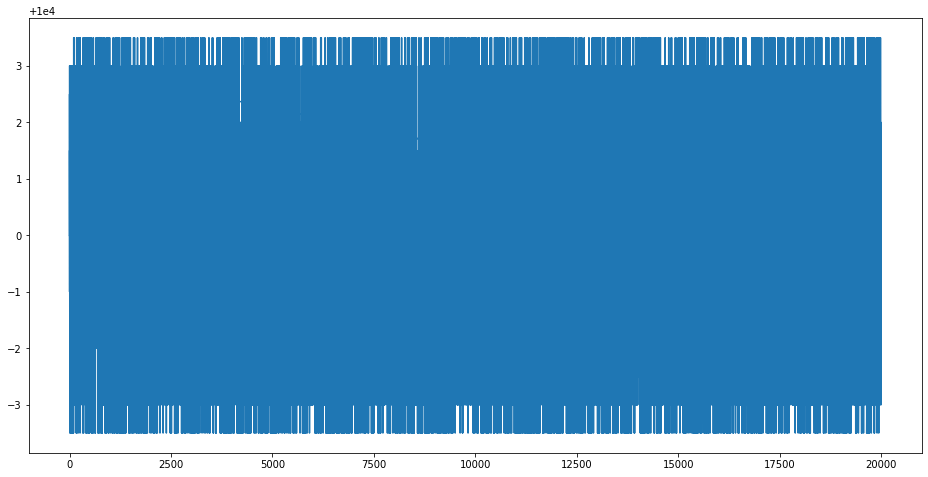

In [99]:
AMETHYSTS_mid_prices = mydf_all['mid_price']
AMETHYSTS_mid_prices.plot(figsize=(16, 8))

The above plot is difficult to visualize, but if we focus on a small period we can see the price pattern:

<AxesSubplot:>

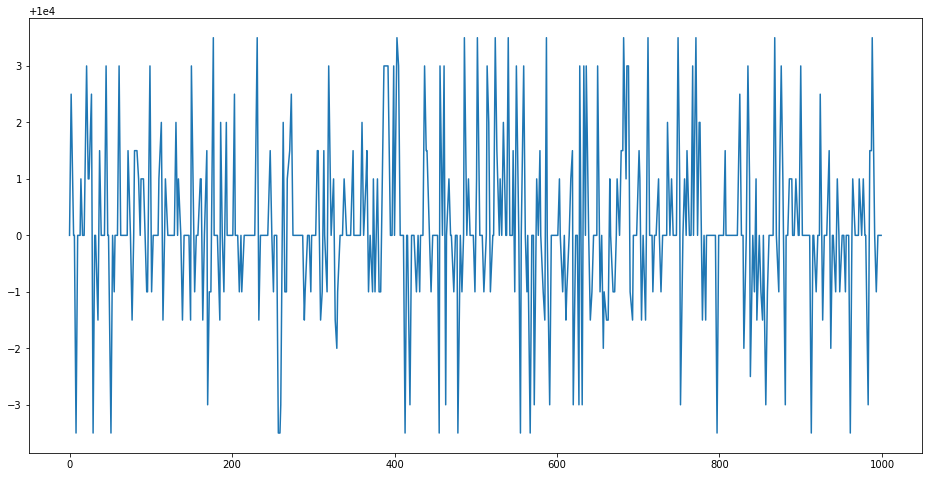

In [100]:
AMETHYSTS_mid_prices.iloc[:500].plot(figsize=(16, 8))

The price oscillates around 10,000 (which is the mean)
A good strategy would be to buy when the price is below 10,000 then sell when the price goes above 10,000, Then short sell when the price is above 0 and buy back when the price goes below 10,000.

Since I don't know how low or high the price will go after crossing zero, I set a threshold for when to buy/sell.
First I estimate the average price deviation from 10,000 using the standard deviation of the series. Then I set the threshold slightly below that, let's say 90% of the standard deviation

In [101]:
AMETHYSTS_mid_prices.std()

1.4965920476507861

In [102]:
AMETHYSTS_mid_prices.mean()

9999.99655

In [103]:
AMETHYSTS_mid_prices.std()*0.90

1.3469328428857075

The sketch below gives a basic idea of the strategy
![title](images/AMETHYSTS_strategy.jpg)

# III) Implementing the strategy

Before I Implement the strategy, let's first undersand the "Market" mechanism in the competition.

- Every 100 time stamps, we receive some information from the exchange about the oustanding orders: buy orders(price and quantity), sell orders (price and quantity), as well as the mid price (average of the best ask and best bid). This information is stored in an object called TradingState.

- The contestants needed to create a class called "Trader" that takes as input the TradingState object of the current timestamp, as well as some info about the previous time stamps and output some orders. 

For now I focus on buying/selling/buying back/short selling 1 unit.
My goal is to see the performance of the strategy with this simple setup before I scale it.

Below is my algorithm:

In [ ]:
# https://imc-prosperity.notion.site/Writing-an-Algorithm-in-Python-658e233a26e24510bfccf0b1df647858#020cacb1ee8247a9992b611d6db3fb13
from datamodel import OrderDepth, TradingState, Order
from typing import List
from statistics import mean
import json



class Trader:

    def run(self, state: TradingState):
        
        #I umpack the information I stored from the previous iterations
        try:
            traderData_unpacked = json.loads(state.traderData)
            first_trade = traderData_unpacked['first_trade_AME']
            previous_op = traderData_unpacked['previous_op_AME']
            position = traderData_unpacked['position_AME']
        except ValueError as e:
            first_trade = True
            previous_op = 'Nothing'
            position = 0
        
  
        # Orders to be placed on exchange matching engine
        result = {} #This variable will contain the orders I place during this iteration for each products
        for product in state.order_depths:
            if product == "AMETHYSTS": #For now I only focus on the security AMETHYSTS
                
                
                # The below parameters are the ones I mention in part II)
                mid_price_mean = 10000
                deviation_threshold = 1.346932
                A = mid_price_mean + deviation_threshold
                B = mid_price_mean - deviation_threshold
                
                
                order_depth: OrderDepth = state.order_depths[product] #Contains the outstanding orders 
                orders: List[Order] = [] #To store my orders during this iteration

                    
                if len(order_depth.sell_orders) != 0: #Checking if there are any outstanding sell orders 
                    
                    
                    #Storing information about the outstanding orders (best bid, best ask and the corresponding 
                    #amounts). I also store the mid price (average of best bid and best ask)
                    best_ask, best_ask_amount = list(order_depth.sell_orders.items())[0]
                    best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]
                    mid_price = (best_ask + best_bid)/2
                    ask_order_num = len(list(order_depth.sell_orders.items()))
                    
                    
                    #Storing the outstanding ask prices and corresponding quantities
                    ask_prices = []
                    ask_order_amounts = []
                    for i in range(ask_order_num):
                        ask_order_amounts.append(list(order_depth.sell_orders.items())[i][1])
                        ask_prices.append(list(order_depth.sell_orders.items())[i][0])
                        
                        
                    max_ask_amount = max(ask_order_amounts)
                    worst_ask = max(ask_prices)
                    traderData_unpacked_new = {} #Come back
                    
                    
                    #The entry point of my algorithm is first time I get a sell order with price lower than B.
                    #I don't send an order to the exchange until this condition is met
                    if first_trade == True and int(best_ask) < B and abs(best_ask_amount)>=1:
                        orders.append(Order(product, best_ask, 1))
                        first_trade = False
                        previous_op = 'BUY'
                        position += 1
                        result[product] = orders
                        break
                        
                    elif first_trade == True and int(best_ask) >= B:
                        break
                        
                    
                    #If my previous operation was a buy, then I need to sell what I bought to make a profit.
                    #I sell only when the price goes above the threshold B
                    #Here, adding 2 units means I buy back what what I short-sold and buy a new unit
                    else:
                        first_trade = traderData_unpacked['first_trade_AME']
                        previous_op = traderData_unpacked['previous_op_AME']
                        if best_ask < B and previous_op == 'SELL' and -best_ask_amount>=2:
                            orders.append(Order(product, best_ask, 2))
                            first_trade = False
                            previous_op = 'BUY'
                            position += 2
                            result[product] = orders
                            break

                if len(order_depth.buy_orders) != 0: #Checking if there are any outstanding buy orders
                    
                    #Unpacking the information I stored from the previous iteration
                    first_trade = traderData_unpacked['first_trade_AME']
                    previous_op = traderData_unpacked['previous_op_AME']
                    
                    
                    #If my previous operation was a sell, then I need to buy back what I sold to make a profit.
                    #I buy only when the price goes below the threshold A.
                    #Here, substracting 2 units means I sold what I bought what I bought and short-sold an 
                    #additional unit
                    best_bid, best_bid_amount = list(order_depth.buy_orders.items())[0]
                    if first_trade == False and best_bid > A and previous_op == 'BUY' and abs(best_bid_amount>=2):
                        orders.append(Order(product, best_bid, -2))
                        previous_op = 'SELL'
                        first_trade = False
                        position -= 2
                        result[product] = orders
                        break

                        
        #Storing the information that I'll carry to the next iteration
        if not 'traderData_unpacked_new' in locals():   
            traderData_unpacked_new = {'first_trade_AME':first_trade,'previous_op_AME':previous_op,'position_AME':position}
        else:
            traderData_unpacked_new['first_trade_AME'] = first_trade
            traderData_unpacked_new['previous_op_AME'] = previous_op
            traderData_unpacked_new['position_AME'] = position
            
        traderData = json.dumps(traderData_unpacked_new)

        conversions = 1

        return result, conversions, traderData


# IV) Backtesting the results 

After writing my algorithm, upload it to the competition website, where It is automatically backtested on some data provided by the host. (So I didn't write a backtest program myself). Below is the cumulative PnL of my current strategy. I achieve a cumulative PnL of 160 at the 1000th iteration. Also my cumulative PnL is increasing, which is a good thing.

<AxesSubplot:>

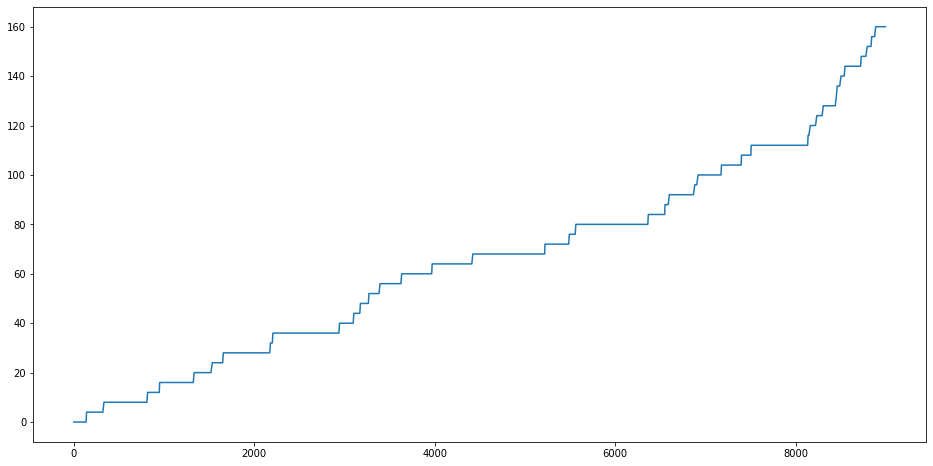

In [107]:
backtest_results = pd.read_csv('Round 4 latest backtest results.csv',delimiter = ";")
backtest_results_starfruit = backtest_results[backtest_results['product'] == 'AMETHYSTS']
backtest_results_starfruit['profit_and_loss'].plot(figsize=(16, 8))

# V) Scaling the strategy

For the implementation above, I only buy/sell 1 incremental unit at a time.
As such, the profits I can makes are very limited. Now that I have a viable strategy, I'll try to scale it.
For that, I need an Idea of the typical order sizes on the exchange.

I first get some histograms for the historical bid and ask order sizes

Histogram for the ask order sizes:

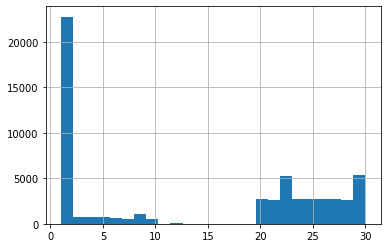

In [52]:
ask_order_sizes = pd.concat([mydf_all['ask_volume_1'],mydf_all['ask_volume_2'],mydf_all['ask_volume_3']]).dropna()
hist_ask_order_sizes = ask_order_sizes.hist(bins=25)

By looking at the histogram above, we can see that ask order sizes are mostly between 1 and 2 or bigger than 18.

Now Let's visualize bid order sizes:

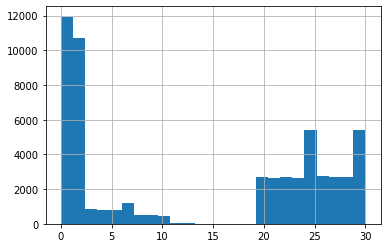

In [53]:
bid_order_sizes = pd.concat([mydf_all['bid_volume_1'],mydf_all['bid_volume_2'],mydf_all['bid_volume_3']]).dropna()
hist_bid_order_sizes = bid_order_sizes.hist(bins=25)

The tendency for buy orders seems to be similar to sell orders

If we want scale the strategy to have order sizes bigger than 18, we need to make sure that we'll still be profitable, i.e:

If we buy let's say 20 units, we need to able to sell those 20 units fairly quickly at a higher price than the one we bought them for. The same logic applies if we short sell 20 units.

To verify the above, I plot the prices over time of the bid orders and ask orders with sizes bigger than 18.


In [66]:
mydf_all_bigger_than_18 = mydf_all
mydf_all_bigger_than_18['bid_price_1'] = mydf_all_bigger_than_18['bid_price_1'].where(mydf_all_bigger_than_18['bid_volume_1']>18)
mydf_all_bigger_than_18['ask_price_1'] = mydf_all_bigger_than_18['ask_price_1'].where(mydf_all_bigger_than_18['ask_volume_1']>18)
mydf_all_bigger_than_18['bid_price_2'] = mydf_all_bigger_than_18['bid_price_2'].where(mydf_all_bigger_than_18['bid_volume_2']>18)
mydf_all_bigger_than_18['ask_price_2'] = mydf_all_bigger_than_18['ask_price_2'].where(mydf_all_bigger_than_18['ask_volume_2']>18)
mydf_all_bigger_than_18['bid_price_3'] = mydf_all_bigger_than_18['bid_price_3'].where(mydf_all_bigger_than_18['bid_volume_3']>18)
mydf_all_bigger_than_18['ask_price_3'] = mydf_all_bigger_than_18['ask_price_3'].where(mydf_all_bigger_than_18['ask_volume_3']>18)


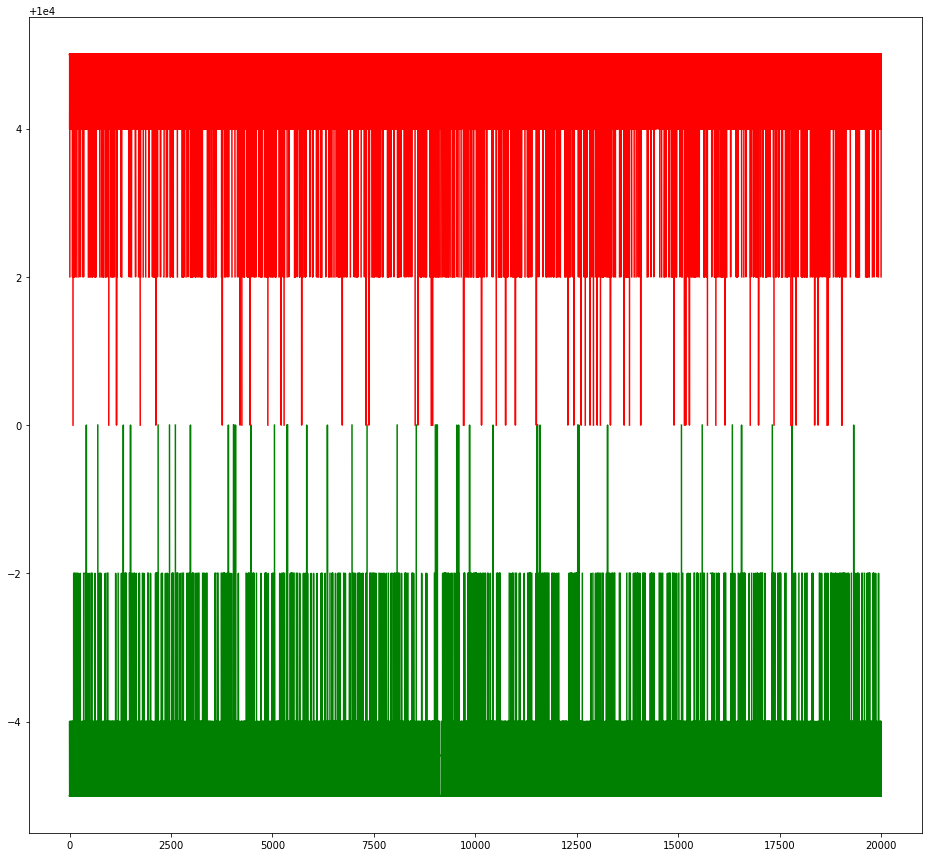

In [94]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,15))
values_to_plot = ['bid_price_1','bid_price_2','bid_price_3','ask_price_1','ask_price_2','ask_price_3']
#for i in values_to_plot:
    #plt.plot(mydf_all_bigger_than_18[[values_to_plot[i]]],color = 'green')
#plt.plot(mydf_all_bigger_than_18[['bid_price_1','bid_price_2','bid_price_3','ask_price_1','ask_price_2','ask_price_3']])
plt.plot(mydf_all_bigger_than_18['bid_price_1'],color = 'green')
plt.plot(mydf_all_bigger_than_18['bid_price_2'],color = 'green')
plt.plot(mydf_all_bigger_than_18['bid_price_3'],color = 'green')

plt.plot(mydf_all_bigger_than_18['ask_price_1'],color = 'red')
plt.plot(mydf_all_bigger_than_18['ask_price_2'],color = 'red')
plt.plot(mydf_all_bigger_than_18['ask_price_3'],color = 'red')

#plt.ylim(bottom = 9998, top = 10002)

plt.show()

By looking at the picture above, we can see that for order sizes bigger than 18, all ask prices are higher than bid prices. Therefore, by scaling the strategy to at least 18 additional units, we wouldn't be able to profit by buying/selling all those units at once.

We sell/buy units bought/sold by spreading the liquidation accross multiple timestamps, but since the remaining order sizes are between 1 and 2 and the price will be different for the following iterations, it will take a long time to liquidate the position.

For those reasons, I didn't scale the strategy and only bought/sold one additional unit at a time.

# VI) Market results

At the end of each round, the algorithm is ran on a ficitional "Market" for the product. Here's what I got for my algorithm at the end of round 3. I get a cumulative PnL of 1140 at the 10,000 th iteration.

<AxesSubplot:>

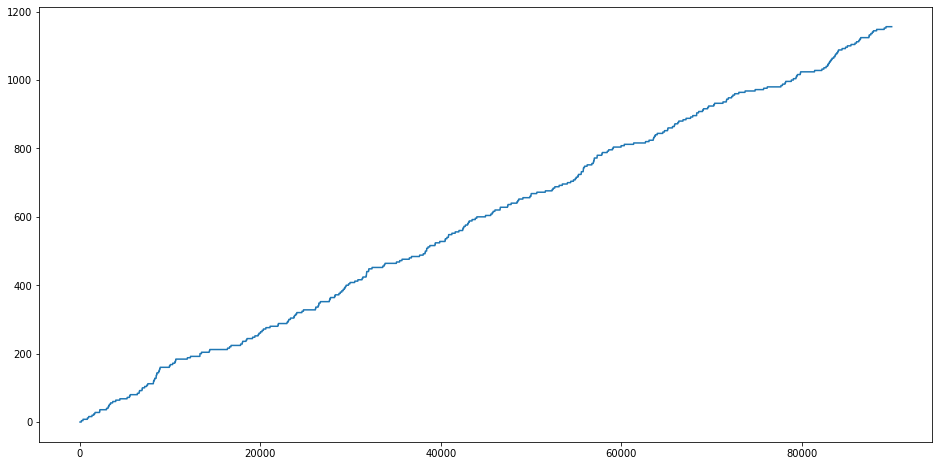

In [104]:
round4_market_pnls = pd.read_csv('Round 4 Market pnls.csv', delimiter = ';')
round4_market_pnls_AMETHYSTS = round4_market_pnls[round4_market_pnls['product']=='AMETHYSTS']
round4_market_pnls_AMETHYSTS['profit_and_loss'].plot(figsize = (16,8))